# 00. 라이브러리 로드

In [56]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

import keras

2.6.0
1.21.4


# 01. ResNet Model 설계

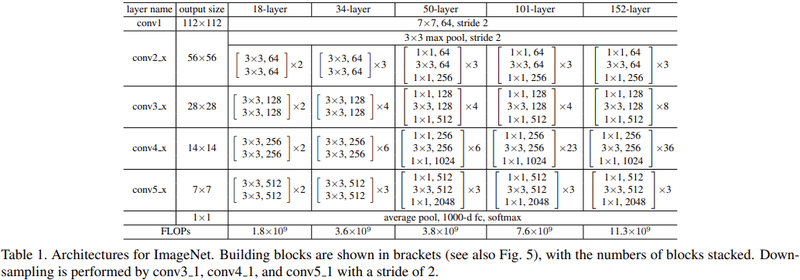

### 01_1. ResNet block

In [38]:
def build_resnet_block(x, filters, blocks, stride=1, is_plain=False, is_50=False):

    expansion = 4 if is_50 else 1

    for i in range(blocks):
        stride_current = stride if i == 0 else 1
        shortcut = x

        if is_50:
            # Bottleneck 블록
            x = keras.layers.Conv2D(filters, kernel_size=1, strides=stride_current, padding='same',
                                    kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',
                                    kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(filters * expansion, kernel_size=1, strides=1, padding='same',
                                    kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)
        else:
            # Basic 블록
            x = keras.layers.Conv2D(filters, kernel_size=3, strides=stride_current, padding='same',
                                    kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',
                                    kernel_initializer='he_normal')(x)
            x = keras.layers.BatchNormalization()(x)

        if not is_plain:
            if stride_current != 1 or keras.backend.int_shape(shortcut)[-1] != filters * expansion:
                shortcut = keras.layers.Conv2D(filters * expansion, kernel_size=1, strides=stride_current,
                                               padding='same', kernel_initializer='he_normal')(shortcut)
                shortcut = keras.layers.BatchNormalization()(shortcut)
            x = keras.layers.Add()([x, shortcut])

        x = keras.layers.Activation('relu')(x)

    return x

### 01_2. ResNet Build

In [39]:
def build_resnet(input_shape, num_classes, is_50=False, is_plain=False):

    inputs = keras.layers.Input(shape=input_shape)

    # 초기 레이어
    x = keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same',
                            kernel_initializer='he_normal',name='input layer')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    if is_50:
        # ResNet-50 설정
        layers = [3, 4, 6, 3]
        filters = [64, 128, 256, 512]
    else:
        # ResNet-34 설정
        layers = [3, 4, 6, 3]
        filters = [64, 128, 256, 512]

    # 각 스테이지별로 블록을 쌓습니다.
    for i in range(len(layers)):
        stride = 1 if i == 0 else 2
        x = build_resnet_block(x, filters=filters[i], blocks=layers[i], stride=stride,
                               is_plain=is_plain, is_50=is_50)

    # 최종 레이어
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, activation='softmax')(x)

    # 모델 이름 설정
    model_depth = 50 if is_50 else 34
    model_type = 'plainnet' if is_plain else 'resnet'
    model_name = f"{model_type}_{model_depth}"

    model = keras.models.Model(inputs=inputs, outputs=x, name=model_name)

    return model

### 01_3. PlainNet Build 

In [40]:
def build_plainnet(input_shape, num_classes, is_50=False):

    return build_resnet(input_shape, num_classes, is_50=is_50, is_plain=True)

### 01_4. config 

In [49]:
input_shape = (224,224,3)
num_classes = 2

# 02. Complete Model 

### 02_1. ResNet 34

In [50]:
# ResNet-34
resnet34 = build_resnet(input_shape=input_shape, num_classes=num_classes, is_50=False, is_plain=False)
resnet34.summary()


Model: "resnet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_641 (Conv2D)             (None, 112, 112, 64) 9472        input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_645 (BatchN (None, 112, 112, 64) 256         conv2d_641[0][0]                 
__________________________________________________________________________________________________
activation_629 (Activation)     (None, 112, 112, 64) 0           batch_normalization_645[0][0]    
__________________________________________________________________________________________

### 02_2. ResNet 50

In [51]:
# ResNet-50
resnet50 = build_resnet(input_shape=input_shape, num_classes=num_classes, is_50=True, is_plain=False)
resnet50.summary()



Model: "resnet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_677 (Conv2D)             (None, 112, 112, 64) 9472        input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_681 (BatchN (None, 112, 112, 64) 256         conv2d_677[0][0]                 
__________________________________________________________________________________________________
activation_662 (Activation)     (None, 112, 112, 64) 0           batch_normalization_681[0][0]    
__________________________________________________________________________________________

### 02_3. PlainNet 34

In [52]:
# PlainNet-34
plainnet34 = build_plainnet(input_shape=input_shape, num_classes=num_classes, is_50=False)
plainnet34.summary()

Model: "plainnet_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_730 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_734 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_711 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_731 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_735 (Bat (None, 56, 56, 64)        

### 02_4. PlainNet 50

In [53]:
# PlainNet-50
plainnet50 = build_plainnet(input_shape=input_shape, num_classes=num_classes, is_50=True)
plainnet50.summary()

Model: "plainnet_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_763 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_767 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_744 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_764 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_768 (Bat (None, 56, 56, 64)        

# 실험 진행

In [58]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# 다운로드 URL 업데이트
setattr(tfds.image_classification.cats_vs_dogs, '_URL',
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# 1. 데이터셋 로드
(raw_train, raw_validation), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [59]:
# 2. 데이터 전처리 함수 정의
IMG_SIZE = (224, 224)  # ResNet 모델의 입력 크기

def format_example(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

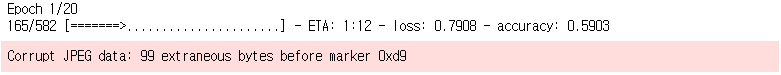

### JPEG 오류로 인한 위 이미지 오류 -> 발생 개수의 변동이 생기긴 하나 예외처리 함수 적용

In [ ]:
def decode_image(image, label):
    try:
        image = tf.image.resize(image, IMG_SIZE)
        image = image / 255.0
        return image, label
    except tf.errors.InvalidArgumentError:
        return None


In [60]:
# 3. 데이터셋에 전처리 적용
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000


train = raw_train.map(lambda x, y: decode_image(x, y)).filter(lambda x: x is not None)
validation = raw_validation.map(lambda x, y: decode_image(x, y)).filter(lambda x: x is not None)

train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation = validation.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [62]:
# 4. 모델 생성

input_shape = (224,224,3)
num_classes = 2

resnet34 = build_resnet(input_shape=input_shape, num_classes=num_classes, is_50=False, is_plain=False)

resnet50 = build_resnet(input_shape=input_shape, num_classes=num_classes, is_50=True, is_plain=False)

plainnet34 = build_plainnet(input_shape=input_shape, num_classes=num_classes, is_50=False)

plainnet50 = build_plainnet(input_shape=input_shape, num_classes=num_classes, is_50=True)

In [63]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()

# 모델 컴파일
resnet34.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
resnet50.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
plainnet34.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
plainnet50.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [111]:
EPOCHS = 20

# 학습 손실을 저장할 딕셔너리 초기화
history_dict = {}

# resnet34 학습
history_resnet34 = resnet34.fit(
    train,
    validation_data=validation,
    epochs=EPOCHS
)
history_dict['resnet34'] = history_resnet34.history

# resnet50 학습
history_resnet50 = resnet50.fit(
    train,
    validation_data=validation,
    epochs=EPOCHS
)
history_dict['resnet50'] = history_resnet50.history

# plainnet34 학습
history_plainnet34 = plainnet34.fit(
    train,
    validation_data=validation,
    epochs=EPOCHS
)
history_dict['plainnet34'] = history_plainnet34.history

# plainnet50 학습
history_plainnet50 = plainnet50.fit(
    train,
    validation_data=validation,
    epochs=EPOCHS
)
history_dict['plainnet50'] = history_plainnet50.history

Epoch 1/20
165/582 [=======>......................] - ETA: 1:12 - loss: 0.0440 - accuracy: 0.9835

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:07 - loss: 0.0412 - accuracy: 0.9850

208/582 [=========>....................] - ETA: 1:05 - loss: 0.0419 - accuracy: 0.9845

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0409 - accuracy: 0.9850

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


165/582 [=======>......................] - ETA: 1:14 - loss: 0.0173 - accuracy: 0.9936

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0181 - accuracy: 0.9934

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0183 - accuracy: 0.9932

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0198 - accuracy: 0.9926

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0224 - accuracy: 0.9917

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0228 - accuracy: 0.9915

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0228 - accuracy: 0.9915

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0234 - accuracy: 0.9912

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0236 - accuracy: 0.9912

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9909

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0242 - accuracy: 0.9909 - val_loss: 0.2250 - val_accuracy: 0.9398
Epoch 3/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0247 - accuracy: 0.9924

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0278 - accuracy: 0.9913

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0289 - accuracy: 0.9911

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0305 - accuracy: 0.9900

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0289 - accuracy: 0.9903

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0283 - accuracy: 0.9905

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0281 - accuracy: 0.9905

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0279 - accuracy: 0.9904

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0277 - accuracy: 0.9905

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9907

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 191ms/step - loss: 0.0275 - accuracy: 0.9907 - val_loss: 0.3755 - val_accuracy: 0.8979
Epoch 4/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0428 - accuracy: 0.9856

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0417 - accuracy: 0.9853

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0406 - accuracy: 0.9857

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0386 - accuracy: 0.9863

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0329 - accuracy: 0.9882

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0327 - accuracy: 0.9882

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0329 - accuracy: 0.9882

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0326 - accuracy: 0.9884

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0325 - accuracy: 0.9884

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9884

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0322 - accuracy: 0.9884 - val_loss: 0.2829 - val_accuracy: 0.9297
Epoch 5/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0187 - accuracy: 0.9934

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0180 - accuracy: 0.9937

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0192 - accuracy: 0.9937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0224 - accuracy: 0.9919

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0215 - accuracy: 0.9928

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0211 - accuracy: 0.9930

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0211 - accuracy: 0.9930

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0204 - accuracy: 0.9932

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0206 - accuracy: 0.9932

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0276 - accuracy: 0.9905

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0287 - accuracy: 0.9898

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0283 - accuracy: 0.9900

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0279 - accuracy: 0.9901

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0278 - accuracy: 0.9900

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0278 - accuracy: 0.9900

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9902

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0272 - accuracy: 0.9902 - val_loss: 0.2632 - val_accuracy: 0.9357
Epoch 7/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0177 - accuracy: 0.9930

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0183 - accuracy: 0.9932

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0181 - accuracy: 0.9934

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0207 - accuracy: 0.9931

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0214 - accuracy: 0.9924

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0214 - accuracy: 0.9925

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0210 - accuracy: 0.9926

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0206 - accuracy: 0.9927

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0206 - accuracy: 0.9927

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9924

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0211 - accuracy: 0.9924 - val_loss: 0.2203 - val_accuracy: 0.9359
Epoch 8/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0185 - accuracy: 0.9934

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0165 - accuracy: 0.9940

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0162 - accuracy: 0.9941

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0133 - accuracy: 0.9953

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0140 - accuracy: 0.9949

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0140 - accuracy: 0.9948

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0145 - accuracy: 0.9947

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0162 - accuracy: 0.9942

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0170 - accuracy: 0.9940

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9938

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0178 - accuracy: 0.9938 - val_loss: 0.3156 - val_accuracy: 0.9241
Epoch 9/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0129 - accuracy: 0.9960

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0175 - accuracy: 0.9945

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0184 - accuracy: 0.9941

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0245 - accuracy: 0.9923

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0229 - accuracy: 0.9928

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0229 - accuracy: 0.9926

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0226 - accuracy: 0.9927

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0225 - accuracy: 0.9926

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0225 - accuracy: 0.9927

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9927

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0220 - accuracy: 0.9927 - val_loss: 0.2986 - val_accuracy: 0.9170
Epoch 10/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0250 - accuracy: 0.9905

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0223 - accuracy: 0.9916

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0228 - accuracy: 0.9913

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0229 - accuracy: 0.9919

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0242 - accuracy: 0.9917

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0244 - accuracy: 0.9916

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0242 - accuracy: 0.9917

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0236 - accuracy: 0.9919

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0235 - accuracy: 0.9919

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9922

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0231 - accuracy: 0.9922 - val_loss: 0.2932 - val_accuracy: 0.9284
Epoch 11/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0137 - accuracy: 0.9968

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0130 - accuracy: 0.9968

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0128 - accuracy: 0.9968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0122 - accuracy: 0.9968

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0146 - accuracy: 0.9956

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0149 - accuracy: 0.9955

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0155 - accuracy: 0.9954

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0164 - accuracy: 0.9950

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0163 - accuracy: 0.9950

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9948

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 191ms/step - loss: 0.0168 - accuracy: 0.9948 - val_loss: 0.2085 - val_accuracy: 0.9372
Epoch 12/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0162 - accuracy: 0.9945

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0159 - accuracy: 0.9945

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0170 - accuracy: 0.9946

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0142 - accuracy: 0.9956

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0159 - accuracy: 0.9949

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0161 - accuracy: 0.9948

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0159 - accuracy: 0.9949

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0162 - accuracy: 0.9947

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0161 - accuracy: 0.9947

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9946

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0164 - accuracy: 0.9946 - val_loss: 0.2175 - val_accuracy: 0.9383
Epoch 13/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0104 - accuracy: 0.9972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0092 - accuracy: 0.9976

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0088 - accuracy: 0.9977

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0095 - accuracy: 0.9973

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0118 - accuracy: 0.9962

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0117 - accuracy: 0.9963

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0116 - accuracy: 0.9963

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0116 - accuracy: 0.9961

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0115 - accuracy: 0.9962

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9961

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.3521 - val_accuracy: 0.9166
Epoch 14/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0258 - accuracy: 0.9907

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0290 - accuracy: 0.9899

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0293 - accuracy: 0.9893

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0252 - accuracy: 0.9908

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0200 - accuracy: 0.9927

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0197 - accuracy: 0.9928

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0198 - accuracy: 0.9927

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0191 - accuracy: 0.9930

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0191 - accuracy: 0.9930

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9931

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 115s 196ms/step - loss: 0.0185 - accuracy: 0.9931 - val_loss: 0.3335 - val_accuracy: 0.9235
Epoch 15/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0215 - accuracy: 0.9928

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0217 - accuracy: 0.9932

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0223 - accuracy: 0.9928

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0201 - accuracy: 0.9934

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0178 - accuracy: 0.9939

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0183 - accuracy: 0.9937

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0180 - accuracy: 0.9938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0179 - accuracy: 0.9939

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0183 - accuracy: 0.9937

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9940

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 191ms/step - loss: 0.0178 - accuracy: 0.9940 - val_loss: 0.1995 - val_accuracy: 0.9452
Epoch 16/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0074 - accuracy: 0.9973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0084 - accuracy: 0.9967

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0106 - accuracy: 0.9962

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0159 - accuracy: 0.9950

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0141 - accuracy: 0.9952

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0139 - accuracy: 0.9953

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0137 - accuracy: 0.9954

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0132 - accuracy: 0.9957

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0132 - accuracy: 0.9956

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9958

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0127 - accuracy: 0.9958 - val_loss: 0.2197 - val_accuracy: 0.9433
Epoch 17/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0150 - accuracy: 0.9949

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0147 - accuracy: 0.9948

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0146 - accuracy: 0.9949

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0130 - accuracy: 0.9956

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0105 - accuracy: 0.9965

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0104 - accuracy: 0.9965

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0107 - accuracy: 0.9965

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0108 - accuracy: 0.9964

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0107 - accuracy: 0.9964

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0111 - accuracy: 0.9962 - val_loss: 0.3865 - val_accuracy: 0.9031
Epoch 18/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0141 - accuracy: 0.9947

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0129 - accuracy: 0.9949

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0127 - accuracy: 0.9950

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0155 - accuracy: 0.9939

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0170 - accuracy: 0.9931

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0166 - accuracy: 0.9933

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0163 - accuracy: 0.9935

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0165 - accuracy: 0.9934

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0165 - accuracy: 0.9934

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9936

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0166 - accuracy: 0.9936 - val_loss: 0.2749 - val_accuracy: 0.9336
Epoch 19/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0179 - accuracy: 0.9939

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0153 - accuracy: 0.9949

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0146 - accuracy: 0.9952

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0122 - accuracy: 0.9960

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0082 - accuracy: 0.9973

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0080 - accuracy: 0.9974

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0079 - accuracy: 0.9974

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0076 - accuracy: 0.9975

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0075 - accuracy: 0.9975

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9976

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.2491 - val_accuracy: 0.9482
Epoch 20/20
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0047 - accuracy: 0.9979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0045 - accuracy: 0.9981

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0044 - accuracy: 0.9982

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0057 - accuracy: 0.9978

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0130 - accuracy: 0.9950

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0137 - accuracy: 0.9948

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0137 - accuracy: 0.9948

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0145 - accuracy: 0.9943

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0145 - accuracy: 0.9943

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9938

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.0162 - accuracy: 0.9938 - val_loss: 0.4233 - val_accuracy: 0.9054
Epoch 1/20
197/582 [=========>....................] - ETA: 2:04 - loss: 0.0648 - accuracy: 0.9757

207/582 [=========>....................] - ETA: 2:01 - loss: 0.0637 - accuracy: 0.9763

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0608 - accuracy: 0.9773

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0640 - accuracy: 0.9761

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0643 - accuracy: 0.9761

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0644 - accuracy: 0.9760

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0640 - accuracy: 0.9760

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0639 - accuracy: 0.9760

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9757

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0647 - accuracy: 0.9757 - val_loss: 0.2980 - val_accuracy: 0.9058
Epoch 2/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0580 - accuracy: 0.9779

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0580 - accuracy: 0.9781

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0614 - accuracy: 0.9771

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0595 - accuracy: 0.9776

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0600 - accuracy: 0.9770

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0597 - accuracy: 0.9771

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0598 - accuracy: 0.9771

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0598 - accuracy: 0.9768

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0598 - accuracy: 0.9769

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9771

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0591 - accuracy: 0.9771 - val_loss: 0.2993 - val_accuracy: 0.8876
Epoch 3/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0434 - accuracy: 0.9838

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0442 - accuracy: 0.9832

207/582 [=========>....................] - ETA: 2:01 - loss: 0.0440 - accuracy: 0.9834

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0418 - accuracy: 0.9840

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0408 - accuracy: 0.9842

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0412 - accuracy: 0.9839

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0418 - accuracy: 0.9837

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0424 - accuracy: 0.9834

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0425 - accuracy: 0.9835

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9832

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0431 - accuracy: 0.9832 - val_loss: 0.2966 - val_accuracy: 0.9054
Epoch 4/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0488 - accuracy: 0.9806

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0500 - accuracy: 0.9805

207/582 [=========>....................] - ETA: 2:01 - loss: 0.0514 - accuracy: 0.9802

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0501 - accuracy: 0.9804

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0473 - accuracy: 0.9816

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0486 - accuracy: 0.9811

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0483 - accuracy: 0.9812

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0490 - accuracy: 0.9810

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0488 - accuracy: 0.9812

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9811

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0491 - accuracy: 0.9811 - val_loss: 0.3246 - val_accuracy: 0.8966
Epoch 5/20
164/582 [=======>......................] - ETA: 2:15 - loss: 0.0462 - accuracy: 0.9829

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0458 - accuracy: 0.9821

207/582 [=========>....................] - ETA: 2:01 - loss: 0.0450 - accuracy: 0.9825

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0466 - accuracy: 0.9821

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0429 - accuracy: 0.9843

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0421 - accuracy: 0.9846

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0417 - accuracy: 0.9848

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0414 - accuracy: 0.9849

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0412 - accuracy: 0.9849

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9851

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0408 - accuracy: 0.9851 - val_loss: 0.2841 - val_accuracy: 0.9175
Epoch 6/20
164/582 [=======>......................] - ETA: 2:15 - loss: 0.0408 - accuracy: 0.9829

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0386 - accuracy: 0.9841

207/582 [=========>....................] - ETA: 2:01 - loss: 0.0401 - accuracy: 0.9840

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0388 - accuracy: 0.9847

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0393 - accuracy: 0.9852

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0389 - accuracy: 0.9853

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0388 - accuracy: 0.9853

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0396 - accuracy: 0.9849

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0399 - accuracy: 0.9848

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9852

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0391 - accuracy: 0.9852 - val_loss: 0.3309 - val_accuracy: 0.9132
Epoch 7/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0340 - accuracy: 0.9886

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0340 - accuracy: 0.9886

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0335 - accuracy: 0.9885

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0336 - accuracy: 0.9878

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0328 - accuracy: 0.9884

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0326 - accuracy: 0.9884

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0329 - accuracy: 0.9884

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0334 - accuracy: 0.9882

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0333 - accuracy: 0.9882

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9883

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


164/582 [=======>......................] - ETA: 2:15 - loss: 0.0393 - accuracy: 0.9840

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0364 - accuracy: 0.9849

207/582 [=========>....................] - ETA: 2:01 - loss: 0.0361 - accuracy: 0.9848

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0411 - accuracy: 0.9839

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0364 - accuracy: 0.9868

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0363 - accuracy: 0.9869

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0362 - accuracy: 0.9870

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0355 - accuracy: 0.9873

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0351 - accuracy: 0.9874

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9879

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 346ms/step - loss: 0.0342 - accuracy: 0.9879 - val_loss: 0.3321 - val_accuracy: 0.9117
Epoch 9/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0533 - accuracy: 0.9798

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0504 - accuracy: 0.9811

207/582 [=========>....................] - ETA: 2:01 - loss: 0.0486 - accuracy: 0.9819

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0417 - accuracy: 0.9848

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0365 - accuracy: 0.9859

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0378 - accuracy: 0.9855

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0376 - accuracy: 0.9856

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0376 - accuracy: 0.9855

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0374 - accuracy: 0.9856

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9853

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0388 - accuracy: 0.9853 - val_loss: 0.3962 - val_accuracy: 0.8820
Epoch 10/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0208 - accuracy: 0.9920

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0197 - accuracy: 0.9919

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0192 - accuracy: 0.9921

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0190 - accuracy: 0.9925

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0257 - accuracy: 0.9904

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0260 - accuracy: 0.9904

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0260 - accuracy: 0.9903

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0262 - accuracy: 0.9902

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0261 - accuracy: 0.9902

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9902

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0268 - accuracy: 0.9902 - val_loss: 0.3454 - val_accuracy: 0.9039
Epoch 11/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0330 - accuracy: 0.9888

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0323 - accuracy: 0.9887

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0327 - accuracy: 0.9884

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0284 - accuracy: 0.9891

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0273 - accuracy: 0.9900

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0273 - accuracy: 0.9900

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0270 - accuracy: 0.9901

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0265 - accuracy: 0.9902

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0266 - accuracy: 0.9902

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9900

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0275 - accuracy: 0.9900 - val_loss: 0.3371 - val_accuracy: 0.9106
Epoch 12/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0424 - accuracy: 0.9840

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0402 - accuracy: 0.9857

207/582 [=========>....................] - ETA: 2:01 - loss: 0.0400 - accuracy: 0.9855

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0401 - accuracy: 0.9854

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0459 - accuracy: 0.9833

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0452 - accuracy: 0.9835

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0449 - accuracy: 0.9835

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0445 - accuracy: 0.9836

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0442 - accuracy: 0.9837

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9841

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0429 - accuracy: 0.9841 - val_loss: 0.2570 - val_accuracy: 0.9147
Epoch 13/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0288 - accuracy: 0.9907

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0292 - accuracy: 0.9903

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0291 - accuracy: 0.9903

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0307 - accuracy: 0.9900

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0272 - accuracy: 0.9908

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0266 - accuracy: 0.9910

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0262 - accuracy: 0.9912

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0254 - accuracy: 0.9915

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0251 - accuracy: 0.9916

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9919

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0242 - accuracy: 0.9919 - val_loss: 0.3302 - val_accuracy: 0.9190
Epoch 14/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0208 - accuracy: 0.9937

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0212 - accuracy: 0.9929

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0210 - accuracy: 0.9929

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0240 - accuracy: 0.9917

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0254 - accuracy: 0.9908

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0254 - accuracy: 0.9909

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0252 - accuracy: 0.9909

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0250 - accuracy: 0.9911

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0248 - accuracy: 0.9912

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9913

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0244 - accuracy: 0.9913 - val_loss: 0.2495 - val_accuracy: 0.9310
Epoch 15/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0223 - accuracy: 0.9910

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0209 - accuracy: 0.9921

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0208 - accuracy: 0.9918

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0249 - accuracy: 0.9905

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0255 - accuracy: 0.9906

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0260 - accuracy: 0.9903

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0261 - accuracy: 0.9902

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0268 - accuracy: 0.9900

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0272 - accuracy: 0.9898

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9896

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0277 - accuracy: 0.9896 - val_loss: 0.3205 - val_accuracy: 0.9222
Epoch 16/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0343 - accuracy: 0.9869

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0320 - accuracy: 0.9876

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0310 - accuracy: 0.9882

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0288 - accuracy: 0.9885

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0248 - accuracy: 0.9904

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0250 - accuracy: 0.9904

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0254 - accuracy: 0.9902

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0264 - accuracy: 0.9901

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0263 - accuracy: 0.9901

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9902

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0261 - accuracy: 0.9902 - val_loss: 0.3336 - val_accuracy: 0.9168
Epoch 17/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0154 - accuracy: 0.9943

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0138 - accuracy: 0.9948

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0137 - accuracy: 0.9947

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0141 - accuracy: 0.9946

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0163 - accuracy: 0.9939

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0167 - accuracy: 0.9937

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0180 - accuracy: 0.9935

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0181 - accuracy: 0.9934

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0182 - accuracy: 0.9933

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9932

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0193 - accuracy: 0.9932 - val_loss: 0.4041 - val_accuracy: 0.8940
Epoch 18/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0264 - accuracy: 0.9907

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0254 - accuracy: 0.9913

207/582 [=========>....................] - ETA: 2:01 - loss: 0.0251 - accuracy: 0.9912

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0263 - accuracy: 0.9908

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0242 - accuracy: 0.9915

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0244 - accuracy: 0.9914

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0250 - accuracy: 0.9911

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0262 - accuracy: 0.9905

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0260 - accuracy: 0.9906

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 0.9904

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0264 - accuracy: 0.9904 - val_loss: 0.3009 - val_accuracy: 0.9245
Epoch 19/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0205 - accuracy: 0.9929

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0219 - accuracy: 0.9930

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0213 - accuracy: 0.9934

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0204 - accuracy: 0.9932

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0211 - accuracy: 0.9932

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0208 - accuracy: 0.9933

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0205 - accuracy: 0.9934

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0201 - accuracy: 0.9934

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0201 - accuracy: 0.9934

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9936

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.3793 - val_accuracy: 0.9091
Epoch 20/20
164/582 [=======>......................] - ETA: 2:14 - loss: 0.0169 - accuracy: 0.9943

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:04 - loss: 0.0185 - accuracy: 0.9938

207/582 [=========>....................] - ETA: 2:00 - loss: 0.0188 - accuracy: 0.9937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:37 - loss: 0.0247 - accuracy: 0.9922

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 30s - loss: 0.0234 - accuracy: 0.9922

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.0231 - accuracy: 0.9924

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 22s - loss: 0.0227 - accuracy: 0.9925

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.0219 - accuracy: 0.9927

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.0217 - accuracy: 0.9928

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9926

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 345ms/step - loss: 0.0221 - accuracy: 0.9926 - val_loss: 0.7972 - val_accuracy: 0.8364
Epoch 1/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0684 - accuracy: 0.9752

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0707 - accuracy: 0.9735

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0692 - accuracy: 0.9742

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0732 - accuracy: 0.9720

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0760 - accuracy: 0.9712

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0761 - accuracy: 0.9710

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0758 - accuracy: 0.9710

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0753 - accuracy: 0.9711

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0752 - accuracy: 0.9711

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9709

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0754 - accuracy: 0.9709 - val_loss: 0.9293 - val_accuracy: 0.8063
Epoch 2/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0835 - accuracy: 0.9670

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0827 - accuracy: 0.9672

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0824 - accuracy: 0.9672

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0781 - accuracy: 0.9684

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0722 - accuracy: 0.9718

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0723 - accuracy: 0.9716

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0721 - accuracy: 0.9717

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0708 - accuracy: 0.9722

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0703 - accuracy: 0.9724

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9728

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0695 - accuracy: 0.9728 - val_loss: 0.2929 - val_accuracy: 0.9125
Epoch 3/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0666 - accuracy: 0.9748

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0665 - accuracy: 0.9746

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0668 - accuracy: 0.9745

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0704 - accuracy: 0.9730

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0686 - accuracy: 0.9739

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0681 - accuracy: 0.9742

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0677 - accuracy: 0.9744

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0678 - accuracy: 0.9744

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0676 - accuracy: 0.9744

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9739

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 182ms/step - loss: 0.0679 - accuracy: 0.9739 - val_loss: 0.4554 - val_accuracy: 0.8796
Epoch 4/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0790 - accuracy: 0.9691

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0753 - accuracy: 0.9705

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0741 - accuracy: 0.9712

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0713 - accuracy: 0.9724

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0679 - accuracy: 0.9730

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0674 - accuracy: 0.9732

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0676 - accuracy: 0.9731

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0667 - accuracy: 0.9737

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0664 - accuracy: 0.9737

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9738

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0665 - accuracy: 0.9738 - val_loss: 0.2733 - val_accuracy: 0.9211
Epoch 5/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0645 - accuracy: 0.9759

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0632 - accuracy: 0.9757

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0618 - accuracy: 0.9764

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0642 - accuracy: 0.9765

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0622 - accuracy: 0.9772

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0619 - accuracy: 0.9772

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0614 - accuracy: 0.9774

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0607 - accuracy: 0.9773

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0609 - accuracy: 0.9772

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9777

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 183ms/step - loss: 0.0601 - accuracy: 0.9777 - val_loss: 0.3117 - val_accuracy: 0.9020
Epoch 6/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0555 - accuracy: 0.9794

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0559 - accuracy: 0.9784

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0544 - accuracy: 0.9791

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0574 - accuracy: 0.9779

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0584 - accuracy: 0.9769

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0594 - accuracy: 0.9767

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0594 - accuracy: 0.9765

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0587 - accuracy: 0.9769

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0589 - accuracy: 0.9769

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9773

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0584 - accuracy: 0.9773 - val_loss: 0.7088 - val_accuracy: 0.8356
Epoch 7/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0535 - accuracy: 0.9795

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0537 - accuracy: 0.9789

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0538 - accuracy: 0.9790

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0565 - accuracy: 0.9782

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0587 - accuracy: 0.9778

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0585 - accuracy: 0.9779

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0580 - accuracy: 0.9781

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0584 - accuracy: 0.9777

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0587 - accuracy: 0.9775

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.9776

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0585 - accuracy: 0.9776 - val_loss: 0.2682 - val_accuracy: 0.9078
Epoch 8/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0483 - accuracy: 0.9845

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0467 - accuracy: 0.9848

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0468 - accuracy: 0.9841

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0458 - accuracy: 0.9845

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0495 - accuracy: 0.9824

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0497 - accuracy: 0.9823

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0497 - accuracy: 0.9824

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0505 - accuracy: 0.9821

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0504 - accuracy: 0.9822

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9819

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0504 - accuracy: 0.9819 - val_loss: 0.2253 - val_accuracy: 0.9314
Epoch 9/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0580 - accuracy: 0.9799

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0582 - accuracy: 0.9803

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0568 - accuracy: 0.9808

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0542 - accuracy: 0.9812

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0557 - accuracy: 0.9805

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0551 - accuracy: 0.9806

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0552 - accuracy: 0.9805

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0538 - accuracy: 0.9812

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0541 - accuracy: 0.9809

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9809

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 182ms/step - loss: 0.0536 - accuracy: 0.9809 - val_loss: 0.3230 - val_accuracy: 0.9061
Epoch 10/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0406 - accuracy: 0.9839

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0432 - accuracy: 0.9833

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0445 - accuracy: 0.9829

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0458 - accuracy: 0.9830

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0497 - accuracy: 0.9813

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0495 - accuracy: 0.9813

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0493 - accuracy: 0.9814

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0489 - accuracy: 0.9815

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0489 - accuracy: 0.9815

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9816

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0482 - accuracy: 0.9816 - val_loss: 0.2407 - val_accuracy: 0.9353
Epoch 11/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0481 - accuracy: 0.9826

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0514 - accuracy: 0.9815

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0513 - accuracy: 0.9812

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0490 - accuracy: 0.9815

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0503 - accuracy: 0.9809

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0506 - accuracy: 0.9807

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0501 - accuracy: 0.9810

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0502 - accuracy: 0.9812

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0499 - accuracy: 0.9814

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.9814

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.0500 - accuracy: 0.9814 - val_loss: 0.3157 - val_accuracy: 0.9071
Epoch 12/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0373 - accuracy: 0.9864

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0379 - accuracy: 0.9861

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0379 - accuracy: 0.9857

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0380 - accuracy: 0.9860

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0377 - accuracy: 0.9862

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0376 - accuracy: 0.9863

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0377 - accuracy: 0.9863

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0388 - accuracy: 0.9854

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0392 - accuracy: 0.9852

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9851

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0397 - accuracy: 0.9851 - val_loss: 0.2753 - val_accuracy: 0.9271
Epoch 13/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0304 - accuracy: 0.9883

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0285 - accuracy: 0.9888

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0283 - accuracy: 0.9890

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0410 - accuracy: 0.9853

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0451 - accuracy: 0.9832

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0454 - accuracy: 0.9832

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0459 - accuracy: 0.9830

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0454 - accuracy: 0.9833

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0453 - accuracy: 0.9833

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9832

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 183ms/step - loss: 0.0459 - accuracy: 0.9832 - val_loss: 0.6006 - val_accuracy: 0.8435
Epoch 14/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0494 - accuracy: 0.9824

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0473 - accuracy: 0.9831

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0462 - accuracy: 0.9835

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0467 - accuracy: 0.9838

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0441 - accuracy: 0.9843

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0433 - accuracy: 0.9847

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0430 - accuracy: 0.9847

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0426 - accuracy: 0.9849

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0425 - accuracy: 0.9849

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9853

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0420 - accuracy: 0.9853 - val_loss: 0.2628 - val_accuracy: 0.9254
Epoch 15/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0452 - accuracy: 0.9847

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0467 - accuracy: 0.9841

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0480 - accuracy: 0.9836

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0479 - accuracy: 0.9840

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0495 - accuracy: 0.9819

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0492 - accuracy: 0.9822

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0488 - accuracy: 0.9822

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0474 - accuracy: 0.9827

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0470 - accuracy: 0.9829

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9832

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0457 - accuracy: 0.9832 - val_loss: 0.2660 - val_accuracy: 0.9308
Epoch 16/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0400 - accuracy: 0.9847

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0383 - accuracy: 0.9852

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0385 - accuracy: 0.9851

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0360 - accuracy: 0.9860

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0410 - accuracy: 0.9845

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0404 - accuracy: 0.9848

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0398 - accuracy: 0.9850

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0392 - accuracy: 0.9853

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0390 - accuracy: 0.9853

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9855

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.0387 - accuracy: 0.9855 - val_loss: 0.2702 - val_accuracy: 0.9261
Epoch 17/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0385 - accuracy: 0.9848

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0445 - accuracy: 0.9836

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0452 - accuracy: 0.9833

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0429 - accuracy: 0.9840

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0389 - accuracy: 0.9853

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0391 - accuracy: 0.9852

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0390 - accuracy: 0.9852

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0395 - accuracy: 0.9849

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0394 - accuracy: 0.9850

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9851

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0392 - accuracy: 0.9851 - val_loss: 0.2821 - val_accuracy: 0.9261
Epoch 18/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0291 - accuracy: 0.9907

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0300 - accuracy: 0.9899

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0298 - accuracy: 0.9902

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0392 - accuracy: 0.9871

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0400 - accuracy: 0.9857

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0399 - accuracy: 0.9858

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0394 - accuracy: 0.9859

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0392 - accuracy: 0.9861

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0390 - accuracy: 0.9862

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9858

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 182ms/step - loss: 0.0405 - accuracy: 0.9858 - val_loss: 0.6069 - val_accuracy: 0.8727
Epoch 19/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0440 - accuracy: 0.9839

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0403 - accuracy: 0.9853

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0396 - accuracy: 0.9856

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0380 - accuracy: 0.9859

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0361 - accuracy: 0.9865

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0362 - accuracy: 0.9865

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0362 - accuracy: 0.9864

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0361 - accuracy: 0.9864

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0363 - accuracy: 0.9862

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9866

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.0354 - accuracy: 0.9866 - val_loss: 0.3133 - val_accuracy: 0.9230
Epoch 20/20
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0197 - accuracy: 0.9930

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0222 - accuracy: 0.9915

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0228 - accuracy: 0.9913

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0293 - accuracy: 0.9892

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0327 - accuracy: 0.9873

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0330 - accuracy: 0.9872

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0329 - accuracy: 0.9872

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0321 - accuracy: 0.9876

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0324 - accuracy: 0.9876

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9879

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0317 - accuracy: 0.9879 - val_loss: 0.3395 - val_accuracy: 0.9295
Epoch 1/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0502 - accuracy: 0.9806

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0495 - accuracy: 0.9810

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0486 - accuracy: 0.9814

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0459 - accuracy: 0.9825

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0484 - accuracy: 0.9822

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0477 - accuracy: 0.9824

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0479 - accuracy: 0.9824

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0477 - accuracy: 0.9823

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0478 - accuracy: 0.9822

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9821

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0475 - accuracy: 0.9821 - val_loss: 0.4024 - val_accuracy: 0.8908
Epoch 2/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0688 - accuracy: 0.9735

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0653 - accuracy: 0.9748

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0665 - accuracy: 0.9749

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0608 - accuracy: 0.9769

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0562 - accuracy: 0.9790

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0558 - accuracy: 0.9791

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0555 - accuracy: 0.9793

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0544 - accuracy: 0.9796

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0543 - accuracy: 0.9797

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9798

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 286ms/step - loss: 0.0550 - accuracy: 0.9798 - val_loss: 1.5381 - val_accuracy: 0.7466
Epoch 3/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0628 - accuracy: 0.9747

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0600 - accuracy: 0.9762

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0593 - accuracy: 0.9763

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0538 - accuracy: 0.9784

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0490 - accuracy: 0.9814

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0483 - accuracy: 0.9817

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0482 - accuracy: 0.9817

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0473 - accuracy: 0.9821

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0471 - accuracy: 0.9822

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9820

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0488 - accuracy: 0.9820 - val_loss: 0.7614 - val_accuracy: 0.8300
Epoch 4/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0482 - accuracy: 0.9817

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0476 - accuracy: 0.9822

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0476 - accuracy: 0.9822

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0517 - accuracy: 0.9801

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0509 - accuracy: 0.9811

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0509 - accuracy: 0.9812

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0512 - accuracy: 0.9812

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0504 - accuracy: 0.9815

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0503 - accuracy: 0.9815

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9820

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 286ms/step - loss: 0.0492 - accuracy: 0.9820 - val_loss: 0.5564 - val_accuracy: 0.8951
Epoch 5/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0389 - accuracy: 0.9859

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0394 - accuracy: 0.9852

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0445 - accuracy: 0.9838

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0443 - accuracy: 0.9841

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0471 - accuracy: 0.9825

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0473 - accuracy: 0.9823

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0468 - accuracy: 0.9824

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0460 - accuracy: 0.9829

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0461 - accuracy: 0.9828

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9830

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0453 - accuracy: 0.9830 - val_loss: 0.5660 - val_accuracy: 0.8577
Epoch 6/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0348 - accuracy: 0.9878

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0336 - accuracy: 0.9884

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0359 - accuracy: 0.9878

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0417 - accuracy: 0.9853

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0453 - accuracy: 0.9835

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0454 - accuracy: 0.9835

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0457 - accuracy: 0.9834

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0455 - accuracy: 0.9833

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0453 - accuracy: 0.9835

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9839

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0438 - accuracy: 0.9839 - val_loss: 0.2257 - val_accuracy: 0.9291
Epoch 7/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0527 - accuracy: 0.9796

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0540 - accuracy: 0.9789

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0535 - accuracy: 0.9789

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0509 - accuracy: 0.9808

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0515 - accuracy: 0.9804

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0511 - accuracy: 0.9806

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0506 - accuracy: 0.9808

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0503 - accuracy: 0.9811

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0501 - accuracy: 0.9812

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9817

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0490 - accuracy: 0.9817 - val_loss: 0.2723 - val_accuracy: 0.9273
Epoch 8/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0458 - accuracy: 0.9838

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0422 - accuracy: 0.9849

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0419 - accuracy: 0.9851

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0387 - accuracy: 0.9863

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0371 - accuracy: 0.9867

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0369 - accuracy: 0.9868

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0363 - accuracy: 0.9870

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0360 - accuracy: 0.9869

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0360 - accuracy: 0.9868

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9869

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 168s 285ms/step - loss: 0.0357 - accuracy: 0.9869 - val_loss: 0.3432 - val_accuracy: 0.8848
Epoch 9/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0649 - accuracy: 0.9766

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0634 - accuracy: 0.9770

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0645 - accuracy: 0.9771

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0595 - accuracy: 0.9780

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0538 - accuracy: 0.9805

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0541 - accuracy: 0.9806

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0537 - accuracy: 0.9807

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0531 - accuracy: 0.9808

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0529 - accuracy: 0.9808

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9814

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0515 - accuracy: 0.9814 - val_loss: 0.4868 - val_accuracy: 0.8878
Epoch 10/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0386 - accuracy: 0.9851

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0385 - accuracy: 0.9856

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0381 - accuracy: 0.9857

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0340 - accuracy: 0.9873

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0380 - accuracy: 0.9863

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0375 - accuracy: 0.9863

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0372 - accuracy: 0.9864

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0363 - accuracy: 0.9867

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0363 - accuracy: 0.9867

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.9868

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0360 - accuracy: 0.9868 - val_loss: 0.2413 - val_accuracy: 0.9228
Epoch 11/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0371 - accuracy: 0.9882

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0387 - accuracy: 0.9868

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0391 - accuracy: 0.9863

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0361 - accuracy: 0.9870

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0400 - accuracy: 0.9854

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0396 - accuracy: 0.9856

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0394 - accuracy: 0.9855

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0387 - accuracy: 0.9858

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0385 - accuracy: 0.9858

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9861

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0377 - accuracy: 0.9861 - val_loss: 0.4924 - val_accuracy: 0.9011
Epoch 12/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0380 - accuracy: 0.9863

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0361 - accuracy: 0.9872

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0362 - accuracy: 0.9872

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0365 - accuracy: 0.9871

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0371 - accuracy: 0.9866

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0383 - accuracy: 0.9862

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0392 - accuracy: 0.9859

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0392 - accuracy: 0.9858

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0395 - accuracy: 0.9857

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9855

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0400 - accuracy: 0.9855 - val_loss: 0.3601 - val_accuracy: 0.9104
Epoch 13/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0360 - accuracy: 0.9859

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0341 - accuracy: 0.9870

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0356 - accuracy: 0.9863

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0353 - accuracy: 0.9868

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0333 - accuracy: 0.9884

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0351 - accuracy: 0.9878

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0360 - accuracy: 0.9875

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0373 - accuracy: 0.9867

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0372 - accuracy: 0.9867

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9867

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0370 - accuracy: 0.9867 - val_loss: 0.2359 - val_accuracy: 0.9160
Epoch 14/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0375 - accuracy: 0.9869

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0368 - accuracy: 0.9872

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0358 - accuracy: 0.9875

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0336 - accuracy: 0.9882

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0331 - accuracy: 0.9884

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0331 - accuracy: 0.9883

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0329 - accuracy: 0.9883

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0323 - accuracy: 0.9884

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0321 - accuracy: 0.9886

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9888

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0314 - accuracy: 0.9888 - val_loss: 0.4272 - val_accuracy: 0.9093
Epoch 15/20
164/582 [=======>......................] - ETA: 1:50 - loss: 0.0405 - accuracy: 0.9857

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0385 - accuracy: 0.9864

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0376 - accuracy: 0.9867

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0440 - accuracy: 0.9843

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0391 - accuracy: 0.9857

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0396 - accuracy: 0.9854

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0394 - accuracy: 0.9854

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0399 - accuracy: 0.9853

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0403 - accuracy: 0.9852

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9854

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0396 - accuracy: 0.9854 - val_loss: 0.4372 - val_accuracy: 0.9058
Epoch 16/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0409 - accuracy: 0.9849

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0380 - accuracy: 0.9865

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0370 - accuracy: 0.9869

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0327 - accuracy: 0.9881

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0319 - accuracy: 0.9890

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0319 - accuracy: 0.9889

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0325 - accuracy: 0.9887

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0325 - accuracy: 0.9887

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0323 - accuracy: 0.9887

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9887

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0328 - accuracy: 0.9887 - val_loss: 0.2777 - val_accuracy: 0.9074
Epoch 17/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0252 - accuracy: 0.9912

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0270 - accuracy: 0.9902

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0323 - accuracy: 0.9884

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0500 - accuracy: 0.9814

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0439 - accuracy: 0.9834

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0438 - accuracy: 0.9834

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0431 - accuracy: 0.9837

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0429 - accuracy: 0.9839

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0430 - accuracy: 0.9839

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9831

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0450 - accuracy: 0.9831 - val_loss: 0.7218 - val_accuracy: 0.8418
Epoch 18/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0327 - accuracy: 0.9903

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0337 - accuracy: 0.9900

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0337 - accuracy: 0.9896

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0320 - accuracy: 0.9898

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0325 - accuracy: 0.9894

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0320 - accuracy: 0.9896

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0320 - accuracy: 0.9895

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0314 - accuracy: 0.9898

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0314 - accuracy: 0.9898

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.9898

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0307 - accuracy: 0.9898 - val_loss: 0.6889 - val_accuracy: 0.8687
Epoch 19/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0367 - accuracy: 0.9878

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0371 - accuracy: 0.9868

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0372 - accuracy: 0.9866

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0404 - accuracy: 0.9851

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0368 - accuracy: 0.9867

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0369 - accuracy: 0.9868

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0380 - accuracy: 0.9865

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0373 - accuracy: 0.9868

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0372 - accuracy: 0.9867

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9866

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0369 - accuracy: 0.9866 - val_loss: 0.2886 - val_accuracy: 0.9028
Epoch 20/20
164/582 [=======>......................] - ETA: 1:51 - loss: 0.0309 - accuracy: 0.9884

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:42 - loss: 0.0401 - accuracy: 0.9846

207/582 [=========>....................] - ETA: 1:39 - loss: 0.0408 - accuracy: 0.9843

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:20 - loss: 0.0447 - accuracy: 0.9832

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 25s - loss: 0.0405 - accuracy: 0.9843

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 21s - loss: 0.0397 - accuracy: 0.9847

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 18s - loss: 0.0392 - accuracy: 0.9849

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 11s - loss: 0.0382 - accuracy: 0.9852

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 10s - loss: 0.0380 - accuracy: 0.9854

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9858

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 285ms/step - loss: 0.0371 - accuracy: 0.9858 - val_loss: 0.4885 - val_accuracy: 0.8992


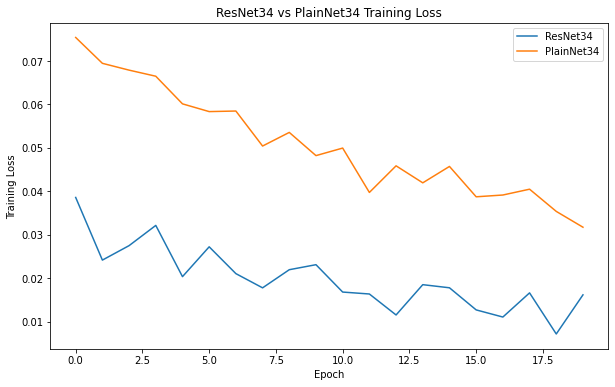

In [112]:
import matplotlib.pyplot as plt
# 34-레이어 모델의 학습 손실 비교
plt.figure(figsize=(10, 6))
plt.plot(history_dict['resnet34']['loss'], label='ResNet34')
plt.plot(history_dict['plainnet34']['loss'], label='PlainNet34')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('ResNet34 vs PlainNet34 Training Loss')
plt.legend()
plt.show()

### ResNet34 Model Training loss 비교 결과

#### 학습 손실 비교를 통해서는 ResNet이 학습이 더빠르게  진행되는 것을 확인할 수 있었다. 
#### 왜 이러한 결과가 나타날지? 
#### 단순히 skip connection을 사용하는 것만으로도 학습이 빠르게 진행되는 이유는 gradient vanishing문제와 관련이 있다. skip connection은 add 층에서 입력을 직접 연결하며, H(x)= F(x)+x로 표현된다. 잔차 연결은 역전파 과정에서 기울기(gradient)가 사라지지 않고 일정한 크기를 유지하도록 하여서 가중치 업데이트가 원활하게 이루어지도록 한다
#### 역전파 과정ㅇ에서 기울기가 계속 곱해져 손실은 최소화하는 과정에서 기울기가 매우 작은 값에 수렴하게 되는 문제가 발생한다. 이를 gradient vanishing 문제라고 하며, 결과적으로 많은 층에서 가중치 업데이트가 이루어지지 않아 학습 속도가 매우 느려지게 된다. 여기서 skip connection은 x의 미분값인 1이 더해져 가중치 업데이트에 영향을 주는 요인이 된다. 이 부분이 ResNet에서 skip connection이 핵심적인 역할을 한다.
#### skip connection은 입력 x에 출력을 직접 더해주어 역전파 시 기울기의 경로를 보존하고, gradient vanishing을 방지한다. 따라서 더 깊은 네트워크에서도 학습이 원활하게 진행될 수 있도록 함과 동시에 학습 속도에도 영향을 준다.

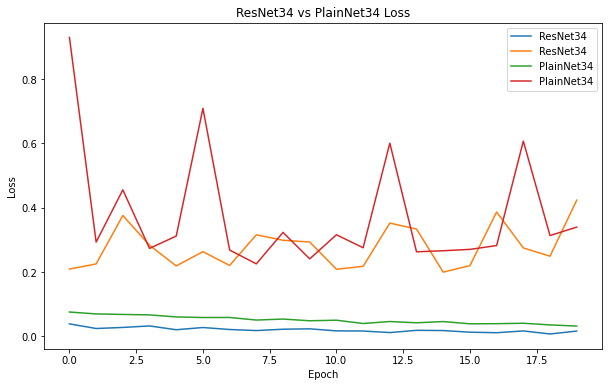

In [113]:
# 34-레이어 모델의 손실 비교
plt.figure(figsize=(10, 6))
plt.plot(history_dict['resnet34']['loss'], label='ResNet34')
plt.plot(history_dict['resnet34']['val_loss'], label='ResNet34')
plt.plot(history_dict['plainnet34']['loss'], label='PlainNet34')
plt.plot(history_dict['plainnet34']['val_loss'], label='PlainNet34')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet34 vs PlainNet34 Loss')
plt.legend()
plt.show()

### ResNet34 vs Plain34 Model Training-Validation Loss 비교 결과

#### 검증 손실을 비교했을 때, ResNet이 더 안정적인 학습을 유지하는 것을 확인할 수 있다. 또한 val_loss값이 더 작았다.
#### 왜 이러한 결과가 나타났을까?
#### Plain net 비교해서 더욱 안정적인 학습이 가능하다는 것을 직관적으로 확인할 수 있는 그래프가 확인되었다. ResNet은 학습손실이 꾸준히 감소하고 검증손실 또한 어느정도 안정화되면서 좋은 성능을 보여준다. 이는 skip connection이 gradient vanishing을 해결하여 좋은 성능을 보여준다는 것을 확인할 수 있음과 동시에 gradient vanishing의 문제로 인한 더딘 학습 속도를 개선하는 경우까지 확인이 가능하다. 

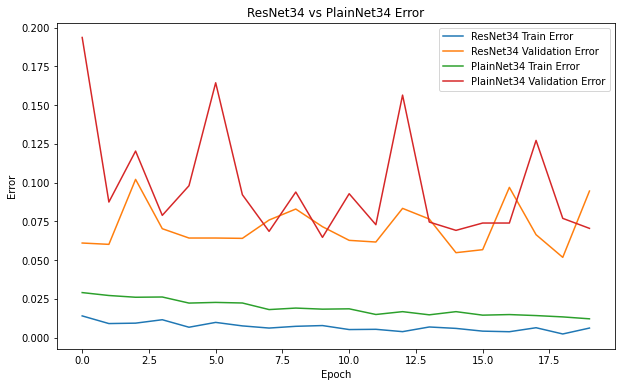

In [114]:
# 34-레이어 모델의 정확도 비교
plt.figure(figsize=(10, 6))
plt.plot(1 - np.array(history_dict['resnet34']['accuracy']), label='ResNet34 Train Error')
plt.plot(1 - np.array(history_dict['resnet34']['val_accuracy']), label='ResNet34 Validation Error')
plt.plot(1 - np.array(history_dict['plainnet34']['accuracy']), label='PlainNet34 Train Error')
plt.plot(1 - np.array(history_dict['plainnet34']['val_accuracy']), label='PlainNet34 Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('ResNet34 vs PlainNet34 Error')
plt.legend()
plt.show()

### ResNet34 vs Plain34 Model Training-Validation Error 비교 결과

#### 1-acc를 통해 Error를 계산하였다. 결과는 더욱 안정적인 학습이 가능하다는 것을 확인가능하다. (이유는 위에서 설명하므로 생략)

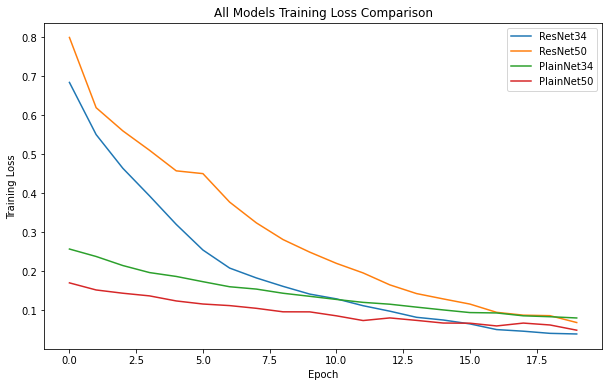

In [107]:
# 모든 모델의 학습 손실 비교
plt.figure(figsize=(10, 6))
plt.plot(history_dict['resnet34']['loss'], label='ResNet34')
plt.plot(history_dict['resnet50']['loss'], label='ResNet50')
plt.plot(history_dict['plainnet34']['loss'], label='PlainNet34')
plt.plot(history_dict['plainnet50']['loss'], label='PlainNet50')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('All Models Training Loss Comparison')
plt.legend()
plt.show()

#### 아직 plainNet의 최적화 지점을 찾지 못했다... 비교 실험에 대한 결과를 정확하게 얻을 수 없으나 어느 정도 확인은 가능하다.

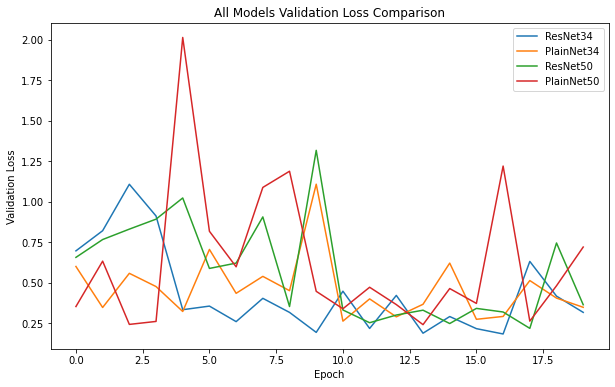

In [108]:
# 모든 모델의 학습 손실 비교
plt.figure(figsize=(10, 6))
plt.plot(history_dict['resnet34']['val_loss'], label='ResNet34')
plt.plot(history_dict['plainnet34']['val_loss'], label='PlainNet34')
plt.plot(history_dict['resnet50']['val_loss'], label='ResNet50')
plt.plot(history_dict['plainnet50']['val_loss'], label='PlainNet50')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('All Models Validation Loss Comparison')
plt.legend()
plt.show()

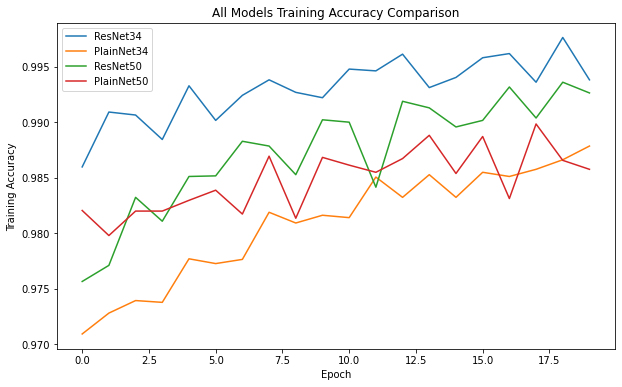

In [115]:
# 모든 모델의 학습 손실 비교
plt.figure(figsize=(10, 6))
plt.plot(history_dict['resnet34']['accuracy'], label='ResNet34')
plt.plot(history_dict['plainnet34']['accuracy'], label='PlainNet34')
plt.plot(history_dict['resnet50']['accuracy'], label='ResNet50')
plt.plot(history_dict['plainnet50']['accuracy'], label='PlainNet50')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('All Models Training Accuracy Comparison')
plt.legend()
plt.show()

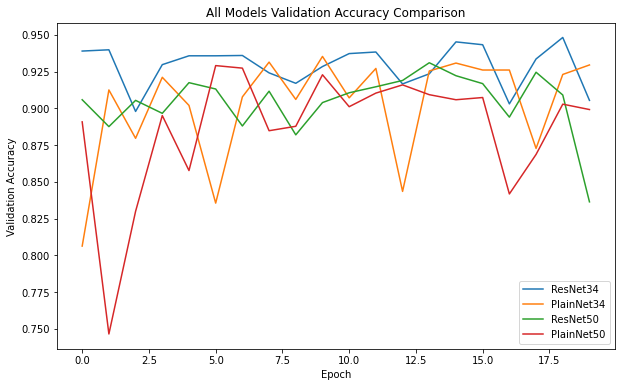

In [116]:
# 모든 모델의 학습 손실 비교
plt.figure(figsize=(10, 6))
plt.plot(history_dict['resnet34']['val_accuracy'], label='ResNet34')
plt.plot(history_dict['plainnet34']['val_accuracy'], label='PlainNet34')
plt.plot(history_dict['resnet50']['val_accuracy'], label='ResNet50')
plt.plot(history_dict['plainnet50']['val_accuracy'], label='PlainNet50')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('All Models Validation Accuracy Comparison')
plt.legend()
plt.show()

## 회고 및 알게된점 : Ablation study...쉽지않다..

### 정당한 비교란 ? 
#### 모델의 Epochs를 동일하게 한다고 정당한 비교라고 할 수 없다. 모델에 따라서 epoch 수는 달라지는 것이 당연하다. 각 모델당 최적화된 지점을 찾았을 때 그 지점에서의 비교가 오히려 정당한 비교가 될수 있다. 모델에 따라 학습이 필요한 반복수는 다르기 때문에... training loss와 val_loss를 비교하여 val_loss가 높아지는 지점을 과대적합이 된 상태이므로 그 전 지점이 최적 적합 지점에서의 모델 성능 비교를 진행하는 것이 비로서 정당한 비교가 되겠다...
